## Import Libraries

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import os
from itertools import chain

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
# import transform_fns as trans
import pdm_functions as fns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from scipy.stats import gaussian_kde
import tensor_hstack as th
import pickle
from tqdm.notebook import tqdm


## Weight계산 

In [3]:
df_normal= pd.read_csv('data/5528_spec_normal.csv')
df_error= pd.read_csv('data/5528_spec_error.csv')

In [4]:
df_normal['spectrum_x_amp']= df_normal['spectrum_x_amp'].apply(lambda x: [float(num) for num in x.split(',')][1:])
df_normal['spectrum_y_amp']= df_normal['spectrum_y_amp'].apply(lambda x: [float(num) for num in x.split(',')][1:])
df_normal['spectrum_z_amp']= df_normal['spectrum_z_amp'].apply(lambda x: [float(num) for num in x.split(',')][1:])

In [5]:
wf = fns.rpm_approx_weighted_fn(df_normal['spectrum_x_amp'], 1, 2048, 2048)

### <span style='color:red'> 가중치 standardization </span>

In [5]:
# wf = fns.min_max_standardization(wf)

In [8]:
wf = wf * 36
wf = torch.tensor(wf)

## 데이터셋 (tensors)

In [7]:
# df_normal = fns.csv_to_tensor_stack('data/5528_spec_normal.csv')
# df_error = fns.csv_to_tensor_stack('data/5528_spec_error.csv')

In [9]:
df_train, df_test, df_dev = th.PostProcessing('data/5528_droped_data.csv', model_type='cls')

In [10]:
df_normal = df_train[0][:-10]
df_error = df_train[0][-10:]

In [11]:
dev_normal = df_dev[0][:-3]

In [12]:
dev_error = df_dev[0][-3:]

## 데이터셋에 가중치 곱하기

In [13]:
print(df_normal.shape, df_error.shape)
df_normal = df_normal * wf
df_error = df_error * wf

torch.Size([111, 73728]) torch.Size([10, 73728])


In [14]:
dev_normal = dev_normal * wf
dev_error = dev_error * wf

## 데이터셋 숫자 늘리기
### <span style='color:red'> 몇 배로 데이터를 늘릴 것인가 multi_dim </span>

In [15]:
df_normal_aug = fns.multi_datasets(df_normal, multi_dim=100, num_groups=12)

In [16]:
df_error_aug = fns.multi_datasets(df_error, multi_dim=1100, num_groups=12)

In [17]:
dev_normal_aug = fns.multi_datasets(dev_normal, multi_dim=10, num_groups=12)

In [18]:
dev_error_aug = fns.multi_datasets(dev_error, multi_dim=100, num_groups=12)

In [19]:
print(df_normal_aug.shape, df_error_aug.shape)
print(dev_normal_aug.shape, dev_error_aug.shape)

torch.Size([11100, 73728]) torch.Size([11000, 73728])
torch.Size([340, 73728]) torch.Size([300, 73728])


In [20]:
X_train, X_test, y_train, y_test= fns.binary_labeling(df_normal_aug, df_error_aug, test_size=.2, random_state=42 )

In [21]:
dev_X_train, dev_X_test, dev_y_train, dev_y_test= fns.binary_labeling(dev_normal_aug, dev_error_aug, test_size=.2, random_state=42 )

## 데이터 상위 x개 추출
### <span style='color:red'> get_sorted_top_k_values(data, k = 5000)</span>

In [22]:
train_X = fns.get_sorted_top_k_values(X_train, 5000)
dev_X_test = fns.get_sorted_top_k_values(dev_X_train, 5000)

In [23]:
train_X.shape, y_train.shape, dev_X_test.shape

(torch.Size([17680, 5000]), torch.Size([17680]), torch.Size([512, 5000]))

### <span style="color:red"> Input값이 너무 작을 경우 곱셈으로 늘려준다 (예: * 1000)  </span>

In [24]:
train_x = fns.get_sorted_top_k_values(train_X, 5000) * 10000

In [25]:
test_x = fns.get_sorted_top_k_values(X_test, 5000) * 10000

In [26]:
test_dev_x = fns.get_sorted_top_k_values(dev_X_test, 5000) * 10000

<Axes: >

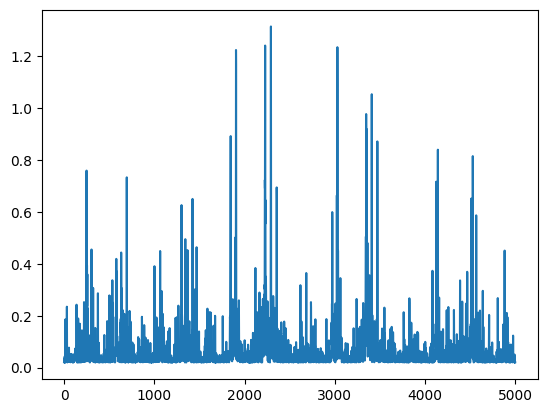

In [27]:
sns.lineplot(train_x[0])

<Axes: >

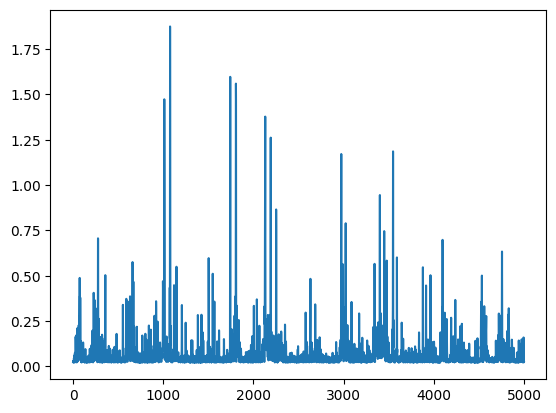

In [28]:
sns.lineplot(test_x[1])

<Axes: >

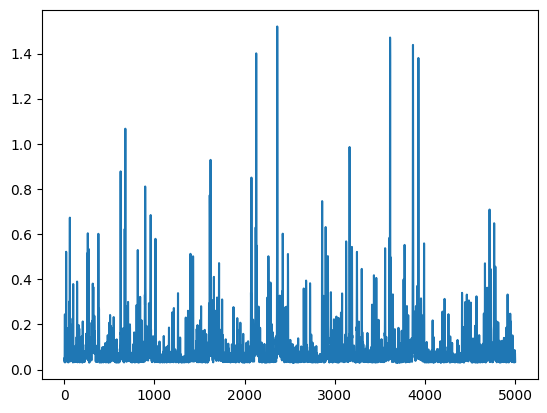

In [28]:
sns.lineplot(test_dev_x[1])

In [29]:
train_label = y_train
test_label = y_test
test_dev_label = dev_y_train

In [30]:
train_x.shape, train_label.shape

(torch.Size([17680, 5000]), torch.Size([17680]))

In [31]:
dev_X_test.shape, test_dev_label.shape

(torch.Size([512, 5000]), torch.Size([512]))

In [32]:
train_dataset = TensorDataset(train_x, train_label)

In [33]:
test_dataset = TensorDataset(test_x, test_label)

In [34]:
dev_dataset = TensorDataset(test_dev_x, test_dev_label)

## 데이터 로더

In [35]:
dataloader = DataLoader(train_dataset, batch_size=120, shuffle=True)

In [36]:
dataloader_test =DataLoader(test_dataset, batch_size= 120, shuffle=False)
dataloader_dev =DataLoader(dev_dataset, batch_size= 120, shuffle=False)

## Model Structure

In [69]:
learning_rate = 0.001
num_epochs = 100
 
model = nn.Sequential(    
    nn.Conv1d(in_channels=1, out_channels=8, kernel_size=4, stride=4, padding=0),  
    nn.ReLU(), 
    nn.MaxPool1d(kernel_size=2),  
    nn.Dropout(0.2),
    nn.Conv1d(in_channels=8, out_channels=16, kernel_size=4, stride=4, padding=0),  
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=2),
    nn.Dropout(0.3),
    nn.Conv1d(in_channels=16, out_channels=8, kernel_size=4, stride=4, padding=0),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Flatten(),
    nn.Linear(152, 64),
    nn.ReLU(), 
    nn.Dropout(0.4),
    nn.Linear(64, 32), 
    nn.ReLU(), 
    nn.Linear(32, 16), 
    nn.ReLU(), 
    nn.Linear(16, 2),
)
 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [70]:
print(model)

Sequential(
  (0): Conv1d(1, 8, kernel_size=(4,), stride=(4,))
  (1): ReLU()
  (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.2, inplace=False)
  (4): Conv1d(8, 16, kernel_size=(4,), stride=(4,))
  (5): ReLU()
  (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.3, inplace=False)
  (8): Conv1d(16, 8, kernel_size=(4,), stride=(4,))
  (9): ReLU()
  (10): Dropout(p=0.4, inplace=False)
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=152, out_features=64, bias=True)
  (13): ReLU()
  (14): Dropout(p=0.4, inplace=False)
  (15): Linear(in_features=64, out_features=32, bias=True)
  (16): ReLU()
  (17): Linear(in_features=32, out_features=16, bias=True)
  (18): ReLU()
  (19): Linear(in_features=16, out_features=2, bias=True)
)


### Model Training

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model.to(device)

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0

    for x_batch, labels in dataloader:
        optimizer.zero_grad()

        # Reshape x_batch to have one input channel
        x_batch = x_batch.unsqueeze(1)  # Reshape: (batch_size, 1, 5000)
        x_batch = x_batch.to(device)  # Move x_batch to device
        labels = labels.to(device)  # Move labels to device
        
        outputs = model(x_batch)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

cuda


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Loss: 0.6928
Epoch [2/100], Loss: 0.6660
Epoch [3/100], Loss: 0.6408
Epoch [4/100], Loss: 0.6222
Epoch [5/100], Loss: 0.6067
Epoch [6/100], Loss: 0.5920
Epoch [7/100], Loss: 0.5737
Epoch [8/100], Loss: 0.5584
Epoch [9/100], Loss: 0.5444
Epoch [10/100], Loss: 0.5323
Epoch [11/100], Loss: 0.5142
Epoch [12/100], Loss: 0.5099
Epoch [13/100], Loss: 0.4978
Epoch [14/100], Loss: 0.4882
Epoch [15/100], Loss: 0.4775
Epoch [16/100], Loss: 0.4724
Epoch [17/100], Loss: 0.4618
Epoch [18/100], Loss: 0.4604
Epoch [19/100], Loss: 0.4564
Epoch [20/100], Loss: 0.4468
Epoch [21/100], Loss: 0.4344
Epoch [22/100], Loss: 0.4460
Epoch [23/100], Loss: 0.4401
Epoch [24/100], Loss: 0.4342
Epoch [25/100], Loss: 0.4284
Epoch [26/100], Loss: 0.4211
Epoch [27/100], Loss: 0.4181
Epoch [28/100], Loss: 0.4104
Epoch [29/100], Loss: 0.4186
Epoch [30/100], Loss: 0.4089
Epoch [31/100], Loss: 0.4086
Epoch [32/100], Loss: 0.4119
Epoch [33/100], Loss: 0.3988
Epoch [34/100], Loss: 0.3980
Epoch [35/100], Loss: 0

## Model Evaluation

In [53]:
model.eval()
 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model.to(device)
 
# Initialize variables to keep track of the loss and predictions
total_loss = 0.0
all_labels = []
all_predictions = []
correct_cnt = 0
miss_cnt = 0

with torch.no_grad():
    for x_batch, labels in dataloader_dev:  # Assuming you have a separate validation or test DataLoader

        # Reshape x_batch to have one input channel
        x_batch = x_batch.unsqueeze(1)  # Reshape: (batch_size, 1, 5000)
        x_batch = x_batch.to(device)  # Move x_batch to device
        labels = labels.to(device)

        # labels = labels.to(device).long() 
        outputs = model(x_batch)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        total_loss += loss.item()  # Accumulate the loss

        # Get predictions
        _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
        all_labels.extend(labels.cpu().numpy())  # Store true labels
        all_predictions.extend(predicted.cpu().numpy())  # Store predicted labels
 
# Calculate average loss
avg_loss = total_loss / len(dataloader)

# Calculate precision, recall, and F1 score
precision = precision_score(all_labels, all_predictions, average='weighted')  # Use 'micro' or 'macro' if needed
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

cm = confusion_matrix(all_labels, all_predictions)
 
TN = cm[0, 0]  
FP = cm[0, 1] 
FN = cm[1, 0]  
TP = cm[1, 1]  

FPR = FP / (FP + TN) if (FP + TN) > 0 else 0  
FNR = FN / (FN + TP) if (FN + TP) > 0 else 0  
 
# Print results
print(f"Evaluation Loss: {avg_loss:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
print(f'Predicted positives out of all negatives: {FPR}')
print(f'Predicted negatives out of all positives: {FNR}')
# print(all_labels)
# print(all_predictions)

for i in range(len(all_labels)):
    if all_labels[i] == 0:  # all_labels의 값이 0인지 확인
        if all_predictions[i] == 0:  # all_predictions의 값이 0인지 확인
            correct_cnt += 1  # cnt를 증가시킴
        else: miss_cnt += 1

print(correct_cnt, miss_cnt, len(all_labels))

cuda
Evaluation Loss: 0.0361
Precision: 0.5859, Recall: 0.5859, F1 Score: 0.5859
Predicted positives out of all negatives: 0.42570281124497994
Predicted negatives out of all positives: 0.40304182509505704
143 106 512


## 모델 저장

In [41]:
# torch.save(model, 'model_v0.0.1.pth')

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import optuna
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Assume that dataloader and dataloader_dev are already defined

def create_model(trial):
    layers = []
    in_channels = 1
    current_size = 5000  # Initial input size

    # Dynamically create convolutional layers
    for i in tqdm(range(trial.suggest_int('n_conv_layers', 1, 5))):
        out_channels = trial.suggest_int(f'conv_{i}_out_channels', 16, 128)
        kernel_size = trial.suggest_int(f'conv_{i}_kernel_size', 3, 7)
        stride = trial.suggest_int(f'conv_{i}_stride', 1, 3)
        
        layers.append(nn.Conv1d(in_channels, out_channels, kernel_size, stride))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(kernel_size=2))
        layers.append(nn.BatchNorm1d(out_channels))
        
        # Calculate the output size of this layer
        current_size = (current_size - kernel_size + 1) // stride
        current_size = current_size // 2  # Effect of MaxPool
        
        in_channels = out_channels

    layers.append(nn.Flatten())

    # Calculate the size of the flattened output
    fc_input_size = in_channels * current_size

    # Dynamically create fully connected layers
    for i in tqdm(range(trial.suggest_int('n_fc_layers', 1, 5))):
        out_features = trial.suggest_int(f'fc_{i}_out_features', 64, 1024)
        layers.append(nn.Linear(fc_input_size, out_features))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(trial.suggest_float(f'dropout_{i}', 0.1, 0.5)))
        fc_input_size = out_features

    # Output layer
    layers.append(nn.Linear(fc_input_size, 2))

    return nn.Sequential(*layers)

def objective(trial):
    # Hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    num_epochs = trial.suggest_int('num_epochs', 10, 50)

    # Create model, loss function, and optimizer
    model = create_model(trial)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        model.train()
        for x_batch, labels in dataloader:
            x_batch = x_batch.unsqueeze(1).to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for x_batch, labels in tqdm(dataloader_dev):
            x_batch = x_batch.unsqueeze(1).to(device)
            labels = labels.to(device)
            
            outputs = model(x_batch)
            _, predicted = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate metrics
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    return f1  # We want to maximize F1 score

# Create a study object and specify the direction is 'maximize' because we want to maximize the F1 score
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective, n_trials=100)  # You can adjust the number of trials

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('Value: ', trial.value)
print('Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

# Train the final model with the best hyperparameters
best_params = study.best_params
final_model = create_model(optuna.trial.FixedTrial(best_params))
final_optimizer = optim.Adam(final_model.parameters(), lr=best_params['lr'])

# ... (여기에 최종 모델 훈련 및 평가 코드 추가)

[I 2024-10-01 15:38:07,805] A new study created in memory with name: no-name-803d6bb6-2e46-415c-94a1-ec7babcdd572
C:\Users\user\AppData\Local\Temp\ipykernel_1200\927846824.py:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
  0%|                                                                                           | 0/38 [00:00<?, ?it/s]
[W 2024-10-01 15:38:07,830] Trial 0 failed with parameters: {'lr': 0.00039486972607855454, 'batch_size': 64, 'num_epochs': 38, 'n_conv_layers': 3, 'conv_0_out_channels': 115, 'conv_0_kernel_size': 5, 'conv_0_stride': 1, 'conv_1_out_channels': 75, 'conv_1_kernel_size': 4, 'conv_1_stride': 3, 'conv_2_out_channels': 17, 'conv_2_kernel_size': 5, 'conv_2_stride': 3, 'n_fc_layers': 2, 'fc_0_out_features': 355, 'dropout_0': 0.22139080861610752, 'fc_

RuntimeError: mat1 and mat2 shapes cannot be multiplied (120x1173 and 1156x355)